In [1]:
#__DATE__: Apr 30
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import warnings
import seaborn
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def acc(true, pred):
    ''' true and pred are labled list
    of the same size
    return the percentage of rightly-prediced labels'''
    return 1.0*(pred==np.asarray(true)).sum()/len(true) 


In [3]:
# read in clean data
sj = pd.read_csv('pluto_yelp_fq_insp.csv')
sanit = pd.read_csv('sanitation_joined.csv')
goog = pd.read_csv('goog_rating_pl.csv')
sj1 = pd.merge(sj, sanit, on = 'CAMIS', how = 'left')
sj1 = pd.merge(sj1, goog, on = 'CAMIS', how = 'left')

In [4]:
sj1['ifA'] = sj1['new_grade'] == 'A' #y
# select features
feat = sj1[[u'yr', u'yrc', u'fcc',
       u'ftc', u'fus', 'google_price_level', u'google_rating', u'NumFloors', u'retail_area_p', u'res_u_p',
       u'alter_time', u'YearBuilt', u'expense/sqft', u'income/spft', 'capture_rate_mgp_total_mgp_max_mgp_']].replace(np.nan, 0)

## DBSCAN: density based anomaly detection

In [5]:
print 'in the whole data set, p(not A) =', 1.0 * sj1[sj1['ifA'] == 0].size/ sj1.size
#print 'in testing data set, p(not A) = ', 1.0 * yte[yte == 0].size/ yte.size

in the whole data set, p(not A) = 0.13021167415


In [6]:
# fit DBSCAN with min_samples:
db = DBSCAN(eps = 0.3, min_samples=3)
db.fit(feat)

sj1['db'] = db.labels_
#print sj1.groupby('db').size()
print 'detected anomaly portion:', 1.0 *sj1.groupby('db').size()[1:].sum()/len(sj1)

detected anomaly portion: 0.014869671701


In [7]:
db2 = DBSCAN(eps = 0.3, min_samples=4)
db2.fit(feat)

sj1['db2'] = db2.labels_
#print sj1.groupby('db2').size()
print 'detected anomaly portion:', 1.0 *sj1.groupby('db2').size()[1:].sum()/len(sj1)

detected anomaly portion: 0.0106711761619


In [8]:
# accuracy
# consider all labels other than '-1' as: not A, which is 0 in our true label list
sj1.db[sj1.db != -1] = 0
sj1.db[sj1.db == sj1.groupby('db').size().index[0]] = 1
print 'DBSCAN with min_sample = 3 accuracy is:', acc(sj1['ifA'], sj1.db)

sj1.db2[sj1.db2 != -1] = 0
sj1.db2[sj1.db2 == sj1.groupby('db2').size().index[0]] = 1
print 'DBSCAN with min_sample = 4 accuracy is:', acc(sj1['ifA'], sj1.db2)

DBSCAN with min_sample = 3 accuracy is: 0.857017901918
DBSCAN with min_sample = 4 accuracy is: 0.860633273077


#### Seems like min_sample = 3 returns higher accuracy. Try visualize them in map:

In [9]:
import os
cwd = os.getcwd()
nycmap = gpd.read_file(os.path.join(cwd, 'nyct2010_16d/nyct2010.shp'))
nycmap = nycmap.to_crs({'init': 'epsg:4326'})

In [10]:
from shapely.geometry import Point
sj1.geometry = sj1.geometry.apply(lambda x: Point((float(x[7:-1].split(' ')[0]), float(x[7:-1].split(' ')[1]))) )
sj1 = gpd.GeoDataFrame(sj1, geometry='geometry')

(-74.299999999999997,
 -73.699999999999989,
 40.400000000000006,
 41.000000000000007)

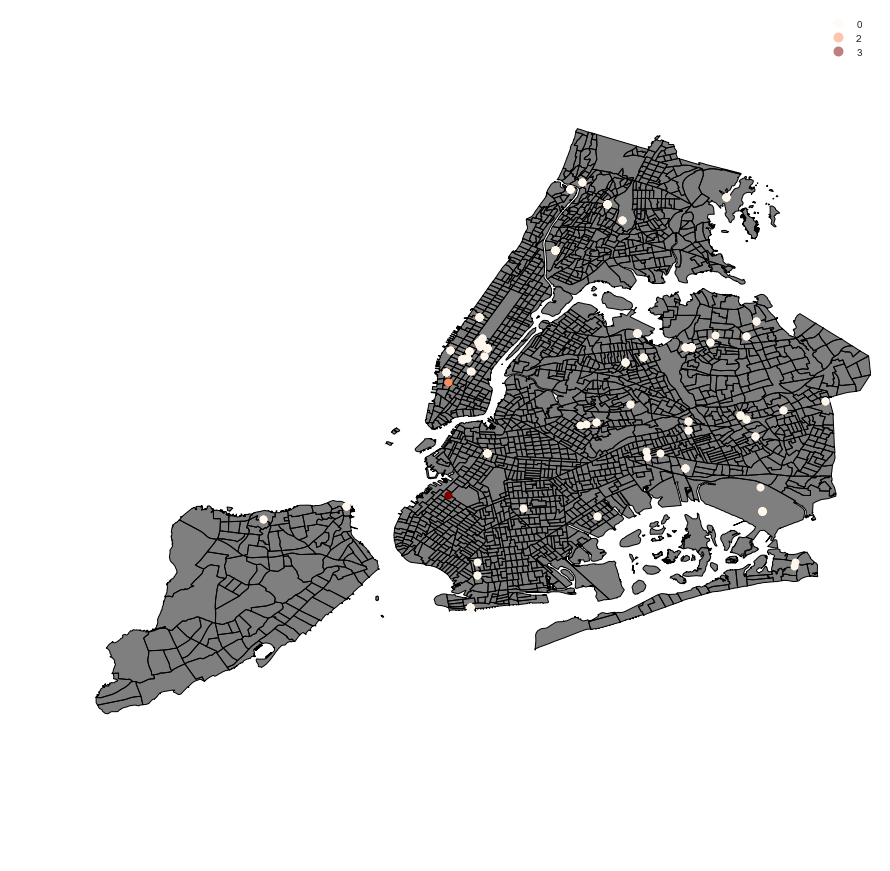

In [11]:
# label another column distinguish true pos 0, true neg 1, false pos 2, false neg 3
sj1['db_'] = sj1.db.copy()
sj1['db_'][sj1.db[(sj1.db == 0) & (sj1.ifA == 1)]] =2
sj1['db_'][sj1.db[(sj1.db == 1) & (sj1.ifA == 0)]] =3

nyc = nycmap.plot(color='black', figsize = [15,15])
sj1[sj1.db_ != 1].plot(ax = nyc, column = 'db_', cmap='OrRd', categorical = True, legend = True, \
                       markersize = 8, linewidth = 0)
plt.axis('off')

(-74.299999999999997,
 -73.699999999999989,
 40.400000000000006,
 41.000000000000007)

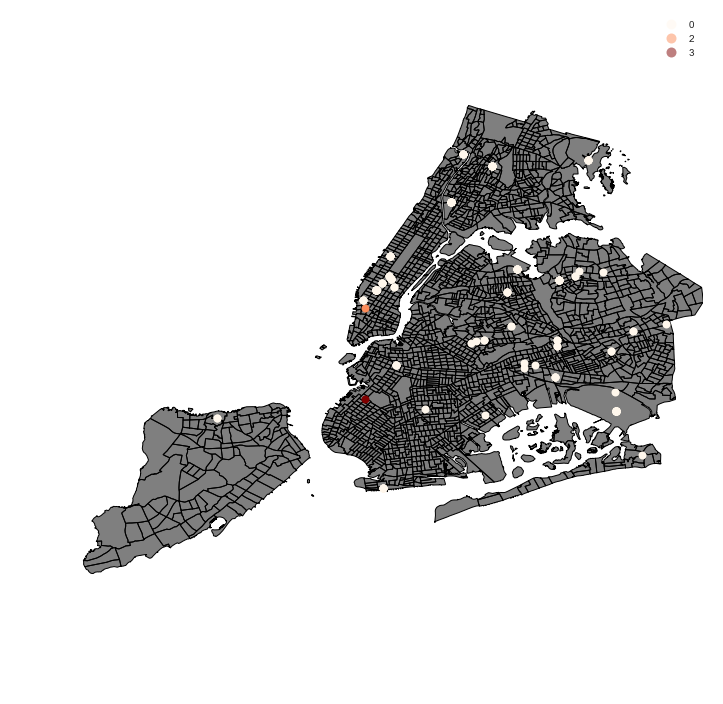

In [12]:
# label another column distinguish true pos 0, true neg 1, false pos 2, false neg 3
sj1['db2_'] = sj1.db2.copy()
sj1['db2_'][sj1.db2[(sj1.db2 == 0) & (sj1.ifA == 1)]] =2
sj1['db2_'][sj1.db2[(sj1.db2 == 1) & (sj1.ifA == 0)]] =3

nyc = nycmap.plot(color='black', figsize = [12,12])
sj1[sj1.db2_ != 1].plot(ax = nyc, column = 'db2_', markersize = 8, cmap='OrRd',\
                        categorical = True, legend = True,  linewidth = 0)
plt.axis('off')

#### mapping doesn't seem to show the results, try visualize on 2-d plot using PCA

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(feat.T)
print(pca.explained_variance_ratio_) 

pca_feat = pd.DataFrame(pca.components_.T)

[  9.96194492e-01   3.51796361e-03   2.82490402e-04   4.80447889e-06
   1.92500312e-07   4.44736472e-08   8.63071981e-09   2.91220091e-09
   2.57100073e-10   1.69423097e-10]


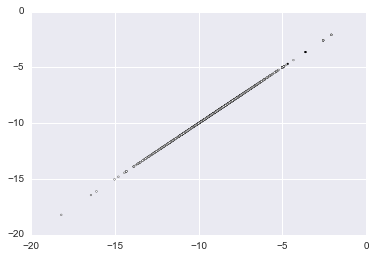

In [14]:
plt.scatter(np.log(pca_feat[0][::10]), np.log(pca_feat[0][::10]), c = sj1.db2[::10], s = 3, cmap = 'gist_heat')
# Hmmmmmmmmmmm??????

## One-class SVM -- need feature preprocessing

In [37]:
# preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

feat_scale = preprocessing.scale(feat)
xtr, xte, ytr, yte = train_test_split(feat_scale, sj1['ifA'], test_size = 0.3, random_state = 99)

In [22]:
# tuning hyperparameters
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'nu': np.linspace(0.1,0.15,8)}]
scores = ['accuracy_score']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.OneClassSVM(), tuned_parameters, cv=5,
                       scoring='accuracy')
    clf.fit(xtr, ytr.astype(int).replace(0, -1))

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
   

# Tuning hyper-parameters for accuracy_score
()
Best parameters set found on development set:
{'kernel': 'rbf', 'nu': 0.10000000000000001, 'gamma': 0.0001}
Grid scores on development set:
0.789 (+/-0.016) for {'kernel': 'rbf', 'nu': 0.10000000000000001, 'gamma': 0.001}
0.785 (+/-0.014) for {'kernel': 'rbf', 'nu': 0.10714285714285715, 'gamma': 0.001}
0.779 (+/-0.014) for {'kernel': 'rbf', 'nu': 0.11428571428571428, 'gamma': 0.001}
0.772 (+/-0.013) for {'kernel': 'rbf', 'nu': 0.12142857142857143, 'gamma': 0.001}
0.767 (+/-0.013) for {'kernel': 'rbf', 'nu': 0.12857142857142856, 'gamma': 0.001}
0.761 (+/-0.014) for {'kernel': 'rbf', 'nu': 0.1357142857142857, 'gamma': 0.001}
0.756 (+/-0.014) for {'kernel': 'rbf', 'nu': 0.14285714285714285, 'gamma': 0.001}
0.750 (+/-0.013) for {'kernel': 'rbf', 'nu': 0.14999999999999999, 'gamma': 0.001}
0.789 (+/-0.015) for {'kernel': 'rbf', 'nu': 0.10000000000000001, 'gamma': 0.0001}
0.784 (+/-0.013) for {'kernel': 'rbf', 'nu': 0.10714285714285715, 'gamma':

In [23]:
param = clf.best_params_

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

# fit the model
clf = svm.OneClassSVM(nu=param['nu'], kernel='rbf', gamma=param['gamma'])
clf.fit(xtr)
# append a new column predicted by SVM
sj1['SVM_pred'] = clf.predict(feat_scale)

y_pred_train = clf.predict(xtr)
y_pred_test = clf.predict(xte)

n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size

print 'detected anomaly portion in traning set:', 1.0 *n_error_train/len(y_pred_train)
print 'detected anomaly portion in testing set:', 1.0 *n_error_test/len(y_pred_test)

print 'out of sample accuracy:' ,acc(yte.astype(int).replace(0, -1), (y_pred_test).astype(int))

detected anomaly portion in traning set: 0.100049983339
detected anomaly portion in testing set: 0.0967930029155
out of sample accuracy: 0.790670553936


In [39]:
y_true, y_pred = yte.astype(int).replace(0, -1), clf.predict(xte)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

         -1       0.08      0.06      0.07       655
          1       0.87      0.90      0.88      4490

avg / total       0.77      0.79      0.78      5145



In [48]:
clf.decision_function(xte)

array([[ 0.96322677],
       [ 0.25919925],
       [ 0.69538281],
       ..., 
       [ 0.65069809],
       [ 0.56894038],
       [ 0.46300615]])

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(feat_scale.T)
print(pca.explained_variance_ratio_)


pca_feat = pd.DataFrame(pca.components_.T)

[ 0.21321976  0.14523208  0.10597965  0.08891956  0.07690281  0.07524063
  0.0686313   0.06542021  0.05992528  0.05340768]
